# Semaine 14 - Reinforcement Learning, Policy Gradient

Dans l'exercice de cette semaine, nous ...

Voici le lien vers la documentation de *Gym*:   https://gym.openai.com/docs/

In [10]:
import numpy as np
import _pickle as pickle
import gym
import matplotlib.pyplot as plt

# L'environnement

Dans Pong, il faut apprendre au joueur de droite à annalyser la trajectoire de la balle et à déplacer la raquette pour renvoyer la balle dans le camps adverse à l'endroit où il ne peut la renvoyer et gagner des points.

In [11]:
env = gym.make('Pong-v0')
env.reset()
for timestep in range(200):
    env.render()
    env.step(2)
env.close()

Le joueur dispose de 6 actions possibles:

In [12]:
env.action_space.n

6

Testez différentes valeurs pour la variable "action" afin de découvrir comment est encodé le choix de l'action pour le passer à l'environnement au travers de la méthode step()

In [13]:
action = 0

env = gym.make('Pong-v0')
env.seed(42)
env.reset()
for timestep in range(200):
    env.render()
    env.step(action)
env.close()

# Les observations et les états

L'environnement fournit à l'agent une image du jeu

In [14]:
env.observation_space

Box(210, 160, 3)

Les observations sont renvoyées par deux différentes méthodes de l'environnement:

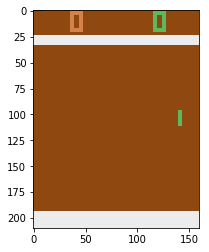

In [15]:
observation = env.reset()
observation, reward, done, info = env.step(action)
plt.imshow(observation) 

# Implémentation du Pong

Hyperparamètres

In [16]:
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = True

Initialization du modèle (réseau de neurones)

In [17]:
# Taille de l'input, une grille de 80x80
D = 80 * 80
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D)
    model['W2'] = np.random.randn(H) / np.sqrt(H)

# ??? (update buffers that add up gradients over a batch)
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } 
# Optimisation (rmsprop memory)
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() }

Fonction sigmoïd pour réduire les valeurs à l'interval [0,1]
 

In [18]:
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x))

On réduit l'image du jeu à un vecteur de 6400 états (pour une grilles de 80x80) avec pour valeurs 0 et 1.

In [19]:
def prepro(I):
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


Discount rewards

""" take 1D float array of rewards and compute discounted reward """

reset the sum, since this was a game boundary (pong specific!)

In [20]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

policy forward

In [1]:
def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

policy backward

In [ ]:
def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

Quelques déclarations de variables

In [ ]:
env = gym.make("Pong-v0")
observation = env.reset()
# used in computing the difference frame
prev_x = None
xs, hs, dlogps, drs = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 0

preprocess the observation, set input to network to be difference image

In [2]:
def get_diff_image():
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    return x

forward the policy network and sample an action from the returned probability

In [4]:
def get_action(x):
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
    return action, h

record various intermediates (needed later for backprop)

In [ ]:
def record_history(x, h):
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)
    return y

In [ ]:
def training():
    while timestep in range(50000):
        if render: env.render()

        x = get_diff_image()

        action, h = get_action(x)

        y = record_history(x, h)

        # step the environment and get new measurements
        observation, reward, done, info = env.step(action)
        reward_sum += reward

        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: # an episode finished
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            eph = np.vstack(hs)
            epdlogp = np.vstack(dlogps)
            epr = np.vstack(drs)
            xs, hs, dlogps, drs = [], [], [], [] # reset array memory

            # compute the discounted reward backwards through time
            discounted_epr = discount_rewards(epr)
            # standardize the rewards to be unit normal (helps control the gradient estimator variance)
            discounted_epr -= np.mean(discounted_epr)
            discounted_epr /= np.std(discounted_epr)

            epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
            grad = policy_backward(eph, epdlogp)
            for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

            # perform rmsprop parameter update every batch_size episodes
            if episode_number % batch_size == 0:
                for k,v in model.items():
                    g = grad_buffer[k] # gradient
                    rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                    model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                    grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

            # boring book-keeping
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            print('resetting env. episode reward total was %f. running mean: %f', reward_sum, running_reward)
            if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
            reward_sum = 0
            observation = env.reset() # reset env
            prev_x = None

            if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
            print('ep %d: game finished, reward: %f', episode_number, reward,'' if reward == -1 else ' !!!!!!!!')

In [ ]:
env = gym.make('Pong-v0')
state = obs_to_state(env.reset())
done = False
while done is False:
    env.render()
    action = greedy_policy(state)
    obs, reward, done, _ = env.step(action)
    state = obs_to_state(obs)
env.close()